In [10]:
%matplotlib inline
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [11]:
from mnist import mnist
train_images = mnist.train_images()[-5000:]
train_labels = mnist.train_labels()[-5000:]
test_images = mnist.test_images()
test_labels = mnist.test_labels()

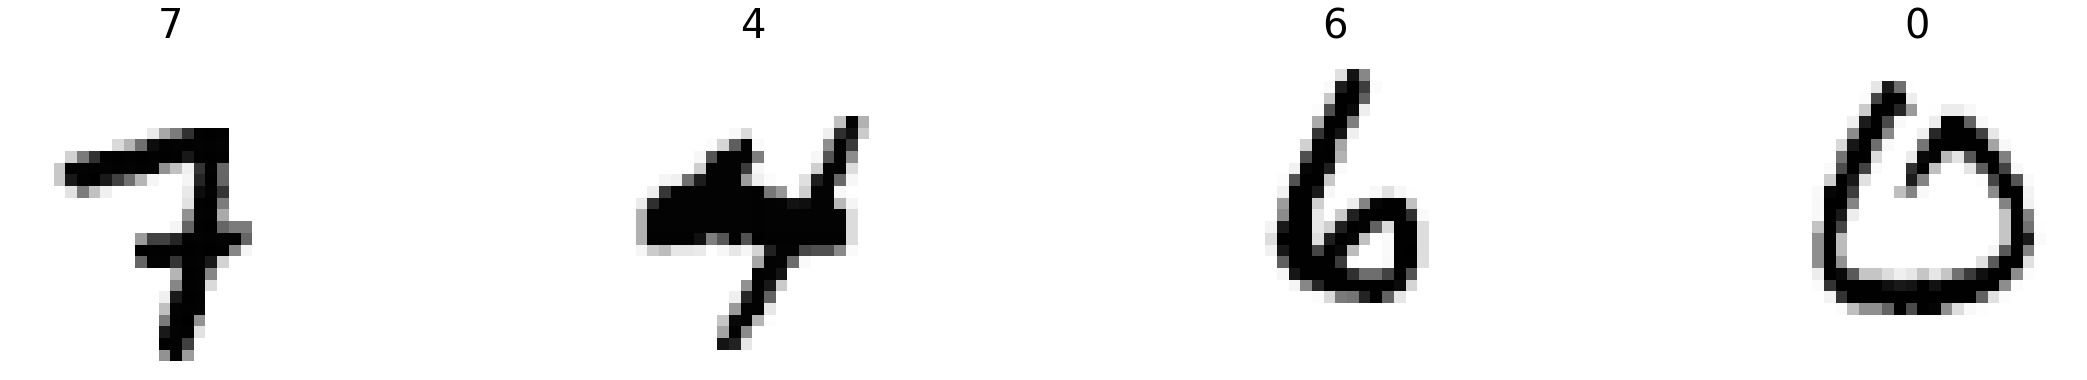

In [23]:
import random
fig, axs = plt.subplots(1, 4)
plt.rcParams['figure.figsize'] = [40, 6]
for i in range(4):
    r = random.randint(0, len(train_images))
    axs[i].imshow(train_images[r], cmap='Greys')
    axs[i].set_title('%d' % train_labels[r], fontsize=40)
    axs[i].axis('off')

In [13]:
class Conv3x3:
    def __init__(self, num_filters):
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3) / 9
        
    def iterate_regions(self, image):
        h, w = image.shape
        for i in range (h - 2):
            for j in range(w - 2):
                sample = image[i : (i + 3), j : (j + 3)]
                yield sample, i, j
                
    def forward(self, image):
        self.input = image
        h, w = image.shape
        output = np.zeros((h - 2, w - 2, self.num_filters))
        for sample, i, j in self.iterate_regions(image):
            output[i, j] = np.sum(sample * self.filters, axis=(1, 2))
        return output
    
    def backprop(self, dLdout, alpha):
        dLdw = np.zeros(self.filters.shape)
        for sample, i, j in self.iterate_regions(self.input):
            for f in range(self.num_filters):
                dLdw[f] += sample * dLdout[i, j, f]
                
        self.filters -= alpha * dLdw
        return None

In [14]:
class MaxPool2:
    def iterate_regions(self, image):
        h, w, f = image.shape
        for i in range (h // 2):
            for j in range(w // 2):
                sample = image[(2*i) : (2*i + 2), (2*j) : (2*j + 2)]
                yield sample, i, j
                
    def forward(self, image):
        self.input = image
        h, w, f = image.shape
        output = np.zeros((h // 2, w // 2, f))
        for sample, i, j in self.iterate_regions(image):
            output[i, j] = np.amax(sample, axis=(0, 1))
        return output
    
    def backprop(self, dLdout, alpha):
        dLdinp = np.zeros(self.input.shape)
        
        for sample, i, j in self.iterate_regions(self.input):
            h, w, f = sample.shape
            amax = np.amax(sample, axis=(0,1))
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        if sample[i2, j2, f2] == amax[f2]:
                            dLdinp[2*i+i2, 2*j+j2, f2] = dLdout[i, j, f2]
        
        return dLdinp

In [15]:
class Softmax:
    def __init__(self, n_inputs, nodes):
        self.weights = np.random.randn(n_inputs, nodes) / n_inputs
        self.biases = np.zeros(nodes)
        
    def forward(self, input):
        self.shape = input.shape
        input = input.flatten()
        self.x = input
        z = np.dot(input, self.weights) + self.biases
        self.z = z
        a = np.exp(z)
        return a / np.sum(a, axis = 0)
    
    def backprop(self, dLdp, alpha):
        for i, gradient in enumerate(dLdp):
            if(gradient == 0):
                continue
                
            a = np.exp(self.z)
            S = np.sum(a)
            
            dpdz = -a[i] * a / (S ** 2)
            dpdz[i] = a[i] * (S - a[i]) / (S ** 2)
            
            dzdw = self.x
            dzdb = 1
            dzdx = self.weights
            
            dLdz = gradient * dpdz
            
            dLdw = dzdw[np.newaxis].T @ dLdz[np.newaxis]
            dLdb = dLdz * dzdb
            dLdx = dzdx @ dLdz
            
            self.weights -= alpha * dLdw
            self.biases -= alpha * dLdb
            
            return dLdx.reshape(self.shape)

In [16]:
import operator

def forward(image, label):
        out = conv.forward((image / 255) - 0.5)
        out = pool.forward(out)
        out = softmax.forward(out)
        loss = -np.log(out[label])
        acc = 1 if np.argmax(out) == label else 0
        return out, loss, acc
    
def display(message, l, preds):
    fig, axs = plt.subplots(1, len(l))
    fig.suptitle(message, fontsize=50, va='top', y=1.3)
    plt.rcParams['figure.figsize'] = [40, 6]
    for i, j in enumerate(l):
        axs[i].imshow(test_images[j], cmap='Greys')
        axs[i].set_title('Actual: %d, Predicted: %d' % (test_labels[j], preds[j]), fontsize=40)
        axs[i].axis('off')
    
def test(k = 4):
    loss = 0
    num_correct = 0
    con = []
    losses = []
    preds = []
    for i, (im, label) in enumerate(zip(test_images, test_labels)):
        conf, l, acc = forward(im, label)
        con.append(conf[label])
        losses.append(l)
        preds.append(np.argmax(conf))
        num_correct += acc
        loss += l
        
        if(i % 1000 == 999):
            print("[Step %d]: Average CE = %.3f, Accuracy = %d%%" % (i + 1, loss / 1000, num_correct / 10))
            loss = 0
            num_correct = 0
        
    con = list(enumerate(con))
    losses = list(enumerate(losses))
    con = sorted(con, key=operator.itemgetter(1))[-k:]
    losses = sorted(losses, key=operator.itemgetter(1))[-k:]
    
    display("Most Confident", list(reversed([i for i, v in con])), preds)
    display("Most Incorrect", list(reversed([i for i, v in losses])), preds)

In [17]:
def train(image, label, alpha=0.005):
    out, loss, acc = forward(image, label)
    
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]
    
    gradient = softmax.backprop(gradient, alpha)
    gradient = pool.backprop(gradient, alpha)
    gradient = conv.backprop(gradient, alpha)
    return loss, acc

In [ ]:
conv = Conv3x3(8)
pool = MaxPool2()
softmax = Softmax(13*13*8, 10)

In [20]:
num_epochs = 3

for i in range(num_epochs):
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]
    
    print("\n------------ EPOCH %d ------------" % (i + 1))
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if(i % 1000 == 999):
            print("[Step %d]: Average CE = %.3f, Accuracy = %d%%" % (i + 1, loss / 1000, num_correct / 10))
            loss = 0
            num_correct = 0

        l, acc = train(im, label)
        loss += l
        num_correct += acc


------------ EPOCH 1 ------------
[Step 1000]: Average CE = 0.176, Accuracy = 94%
[Step 2000]: Average CE = 0.187, Accuracy = 94%
[Step 3000]: Average CE = 0.173, Accuracy = 95%
[Step 4000]: Average CE = 0.209, Accuracy = 93%
[Step 5000]: Average CE = 0.186, Accuracy = 93%

------------ EPOCH 2 ------------
[Step 1000]: Average CE = 0.149, Accuracy = 95%
[Step 2000]: Average CE = 0.153, Accuracy = 95%
[Step 3000]: Average CE = 0.120, Accuracy = 97%
[Step 4000]: Average CE = 0.158, Accuracy = 94%
[Step 5000]: Average CE = 0.176, Accuracy = 94%

------------ EPOCH 3 ------------
[Step 1000]: Average CE = 0.117, Accuracy = 96%
[Step 2000]: Average CE = 0.108, Accuracy = 96%
[Step 3000]: Average CE = 0.140, Accuracy = 96%
[Step 4000]: Average CE = 0.122, Accuracy = 96%
[Step 5000]: Average CE = 0.141, Accuracy = 95%


[Step 1000]: Average CE = 0.281, Accuracy = 92%
[Step 2000]: Average CE = 0.404, Accuracy = 88%
[Step 3000]: Average CE = 0.336, Accuracy = 90%
[Step 4000]: Average CE = 0.348, Accuracy = 89%
[Step 5000]: Average CE = 0.357, Accuracy = 90%
[Step 6000]: Average CE = 0.147, Accuracy = 95%
[Step 7000]: Average CE = 0.224, Accuracy = 93%
[Step 8000]: Average CE = 0.172, Accuracy = 94%
[Step 9000]: Average CE = 0.100, Accuracy = 97%
[Step 10000]: Average CE = 0.268, Accuracy = 92%


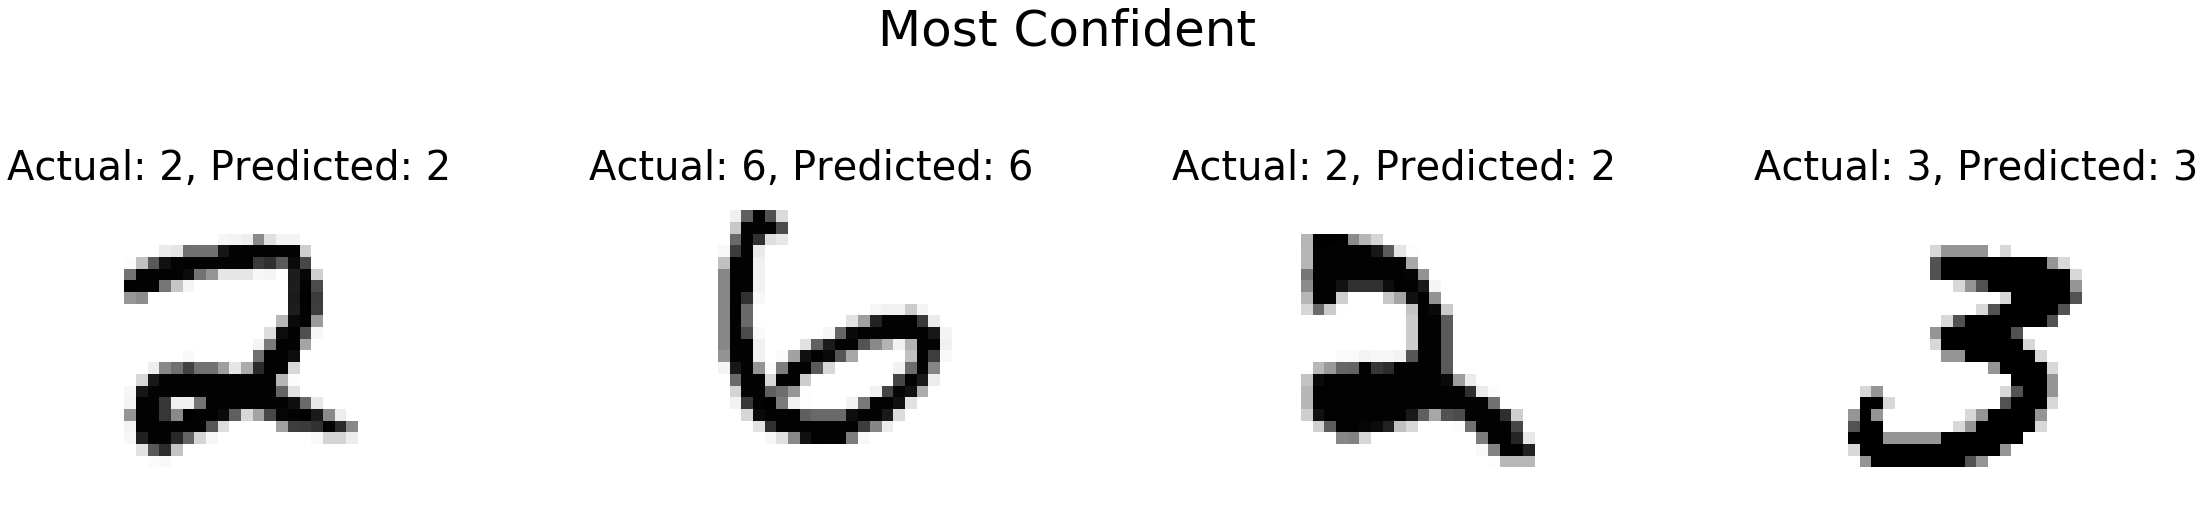

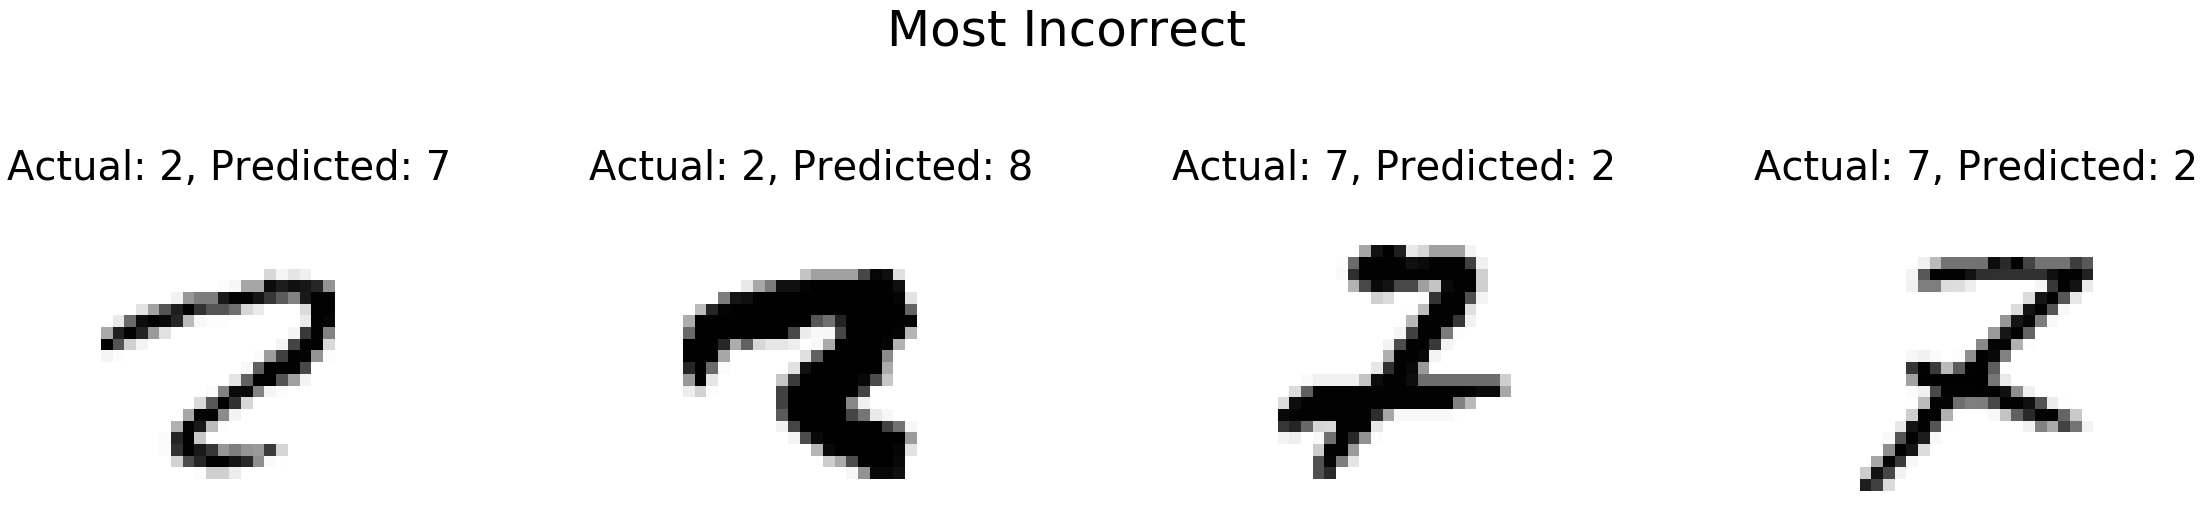

In [21]:
test()